In [ ]:
# to save as tif in google drive
!pip install imagecodecs
# ML model for cell segmentation
# !pip install stardist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pyclesperanto_prototype

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, io, img_as_ubyte
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity

import pyclesperanto_prototype as cle #main algorithm is HERE!!!

import pandas as pd
from glob import glob

import cv2, math
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
work_dir = '/content/drive/MyDrive/Lymphoma_PPFE_vs_Cryo/'          #you might need to change it in your case, look at your folder structure
img_dir = work_dir + 'images_1_CROPPED/'
auto_dir = work_dir + 'images_1_AUTO/alfa/'

In [ ]:
images = glob(img_dir+"*_SELECTED*")                                #select only images containing SELECTED keyword in it

In [ ]:
def color_separate(ihc_rgb):
    ihc_hed = rgb2hed(ihc_rgb)
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_h = img_as_ubyte(hed2rgb(np.stack((ihc_hed[:,:,0], null, null), axis = -1)))
    ihc_e = img_as_ubyte(hed2rgb(np.stack((null, ihc_hed[:,:,1], null), axis = -1)))
    ihc_d = img_as_ubyte(hed2rgb(np.stack((null, null, ihc_hed[:,:,2]), axis = -1)))

    h = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1),
                            in_range = (0, np.percentile(ihc_hed[:,:,0], 99)))
    d = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1),
                            in_range = (0, np.percentile(ihc_hed[:,:,2], 99)))

    zdh = img_as_ubyte(np.dstack((null, d, h)))
    return [ihc_h, ihc_e, ihc_d, zdh]

In [ ]:
img = io.imread(images[0])

In [ ]:
images[0]

'/content/drive/MyDrive/Lymphoma_PPFE_vs_Cryo/images_1_CROPPED/5_L-07 FFPE Exp 16 ms Gain 1 Satur 100_crop_1_SELECTED.tif'

In [ ]:
channels = color_separate(img_gamma1)

In [ ]:
def image_plot(channels, ihc_rgb):
    fig, axs = plt.subplots(1,4)
    fig.set_dpi(200)
    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')
    axs[3].axis('off')
    axs[0].title.set_text('Original')
    axs[1].title.set_text('H')
    axs[2].title.set_text('E')
    axs[3].title.set_text('D')
    axs[0].imshow(ihc_rgb)
    axs[1].imshow(channels[0])
    axs[2].imshow(channels[1])
    axs[3].imshow(channels[2])

In [23]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# compute gamma = log(mid*255)/log(mean)
mid = 0.5
mean = np.mean(gray)
gamma = math.log(mid*255)/math.log(mean)
print(gamma)

# do gamma correction
img_gamma1 = np.power(img, gamma).clip(0,255).astype(np.uint8)

1.0363715790119732


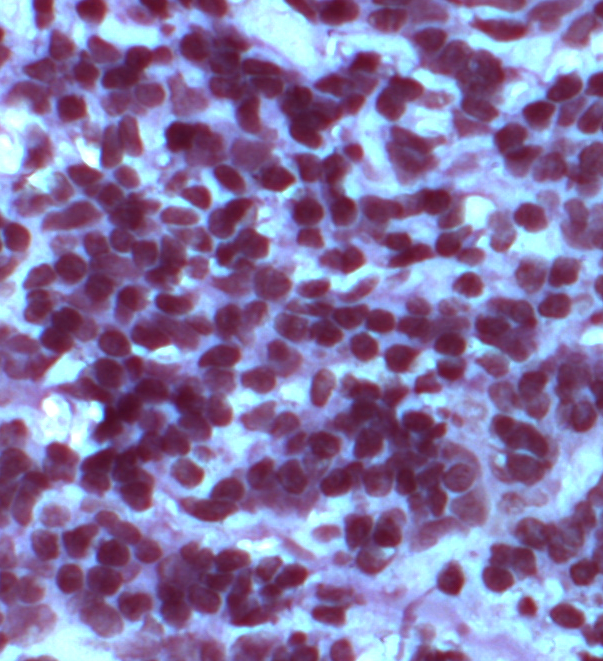

In [ ]:
cv2_imshow(img_gamma1)

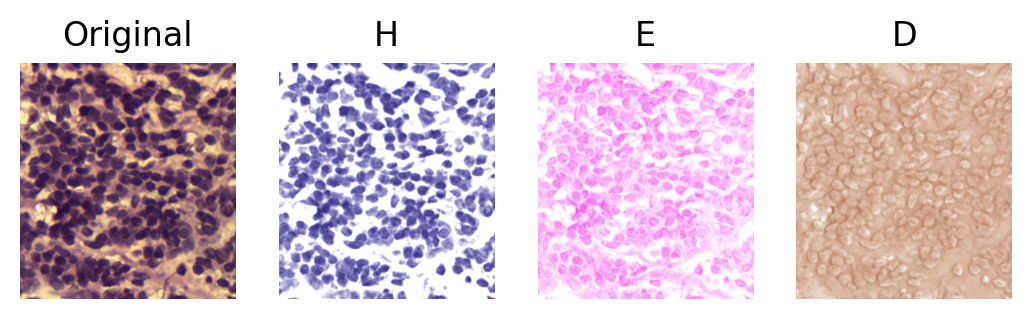

In [ ]:
image_plot(channels, img)

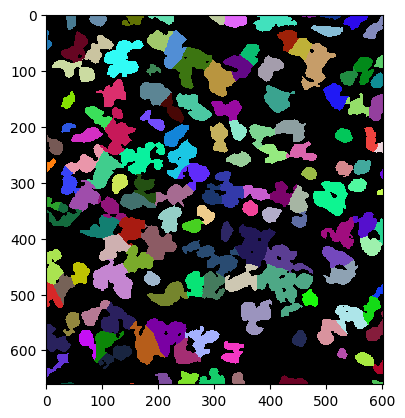

In [ ]:
input_image = np.invert(channels[0][:, :, 2])
# device = cle.select_device(cle.available_device_names(dev_type='gpu')[0])
# device
# input_gpu = cle.push(input_image)
input_gpu = input_image

#IMPORTANT PARAMETERS THAT CAN BE TUNED BY USER
sigma_spot_detection = 10
sigma_outline = 1


segmented = cle.voronoi_otsu_labeling(input_gpu, spot_sigma=sigma_spot_detection, 
                                      outline_sigma=sigma_outline)

statistics = cle.statistics_of_labelled_pixels(input_gpu, segmented) 
table = pd.DataFrame(statistics)  
cle.imshow(segmented, labels=True) 